In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf  
import numpy as np
import pandas as pd
from scipy import optimize

# get data n years from today
def get_price(portfolio,n):
    t_0 = datetime.today() - timedelta(365*n)
    # convert adj_close_price to a matrix, [portfolio] is impt as it sorts column according to sequence in [portfolio]
    return yf.download(portfolio,start=t_0)['Adj Close'][portfolio].to_numpy()

# get covariance matrix
def hist_return_cov_corr(price):
    returns = (price[1:,:] / price[:-1,:])    # convert adj_close_price to daily returns
    returns = returns[~np.isnan(returns).any(axis=1)] # remove row with nan, along the row (axis=1)
    
    return  np.mean(returns,axis=0)**253-1,\
            np.cov(np.transpose(returns))*253,\
            np.corrcoef(np.transpose(returns)) # convert returns to annualized covariance matrix, 253 trading days per year
        
# get cummulative return 
def cum_returns(price):
    price = price[~np.isnan(price).any(axis=1)]
    returns = (price[1:,:] / price[0,:]) - 1
    return returns[~np.isnan(returns).any(axis=1)]

def portfolio_return(w,r):
    return np.dot(np.transpose(w),np.transpose(r))

def portfolio_var(w,cov):
    return np.dot(np.dot(np.transpose(w),cov),w)

# calculate optimal weights under constraints: 
  # 1)min var
  # 2)w'1-1=0
# variance of portfolio = w'*sigma*w, where w is weight column vector & sigma is covariance matrix
# by langrange multiplier(LM) => gradient(var)=lambda*gradient(w'1-1), explain as below
  # consider a 3D object and 2D plane, since gradient vector must be pdclar to contour lines
  # therefore, if 2 gradient vectors // each, the plane will be tangential to the 3D obj => min/max occurs

# calculate optimal weight by LM (after some algebra)
def min_var_weight_LM(cov):
    inv_cov = np.linalg.pinv(cov)
    ones = np.ones(len(inv_cov))
    inv_dot_ones = np.dot(inv_cov, ones)
    return inv_dot_ones/np.dot(np.transpose(inv_dot_ones),ones)

# if we add short selling constraint, we can use scipy.optimize
# to calculate optimal weight 
def min_var_weight_no_ss(cov):
    n = len(cov)
    w = np.ones([n])/n                      # initialize with equal weights
    bound = [(0,1) for i in range(n)]       # weights between 0-1 if short selling is not allowed 
    constraint = ({'type':'eq', 'fun': lambda w: sum(w)-1 })   # Sum of weights = 1
    
    # variance function of portfolio = w'*sigma*w
    def var(w, cov):
        return np.dot(np.dot(np.transpose(w) ,cov),w) 

    ans = optimize.minimize(var, w, (cov), method='SLSQP', constraints=constraint,bounds=bound)  
    return ans.x

def max_sharpe_weight_no_ss(cov, r, rf):
    n = len(cov)
    w = np.ones([n])/n                      # initialize with equal weights
    bound = [(0,1) for i in range(n)]       # weights between 0-1 if short selling is not allowed 
    constraint = ({'type':'eq', 'fun': lambda w: sum(w)-1 })   # Sum of weights = 1
    
    def sharpe(w, cov, r, rf):
        sr = (portfolio_return(w,r)-rf)/portfolio_var(w,cov)
        return 1/sr
        
    ans = optimize.minimize(sharpe, w, (cov,r,rf), method='SLSQP', constraints=constraint,bounds=bound)  
    return ans.x

In [3]:
# basic setting            
portfolio = ['WMT','AMZN','T','V','TSLA','MSFT','UNH','JPM','CAT','PG'] 
#['^GSPC','^FTSE','^N100','^N225','^HSI','^FCHI','^JKSE','^KS11']
#['WMT','AMZN','T','V','TSLA','MSFT','UNH','JPM','CAT','PG'] 

px = get_price(portfolio,5)
returns, cov, corr = hist_return_cov_corr(px)

rf=0.01
min_var_w_LM = min_var_weight_LM(cov)
min_var_w_no_ss = min_var_weight_no_ss(cov)
max_sharpe_w_no_ss = max_sharpe_weight_no_ss(cov, returns, rf)

cum_r = cum_returns(px)
min_var_w_LM_r = portfolio_return(min_var_w_LM,cum_r)
min_var_w_no_ss_r = portfolio_return(min_var_w_no_ss,cum_r)
max_sharpe_w_no_ss_r = portfolio_return(max_sharpe_w_no_ss,cum_r)

# display all optimal weights in a dataframe
weight_table = pd.DataFrame(data= min_var_w_LM, columns = ['min_var_weight_LM'], index = portfolio)
weight_table['min_var_weight_no_ss'] = min_var_w_no_ss
weight_table['max_sharpe_weight_no_ss'] = max_sharpe_w_no_ss

[*********************100%***********************]  10 of 10 completed


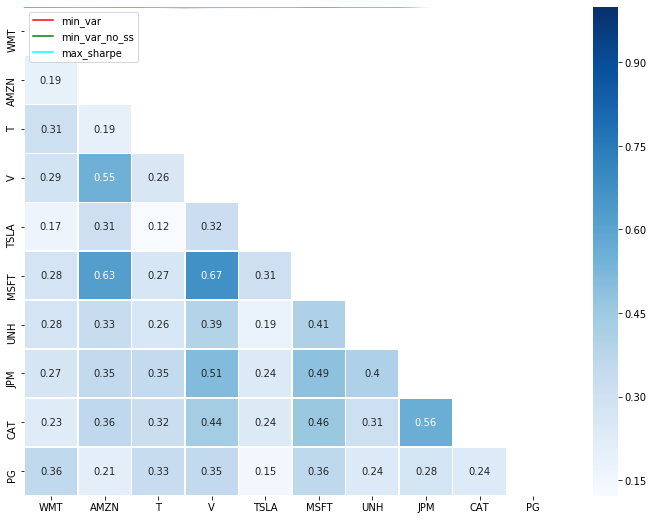

In [4]:
# display correlation heat map
plt.figure(figsize=(12, 9))
sb.heatmap(corr, annot=True, mask=np.triu(corr),yticklabels=portfolio,xticklabels=portfolio,linewidths=.5,cmap="Blues")


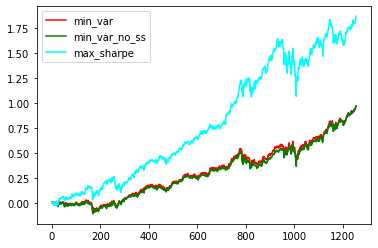

In [5]:
# plot cummulative return using diff weights
plt.plot(min_var_w_LM_r, color='red', label="min_var")
plt.plot(min_var_w_no_ss_r, color='green', label="min_var_no_ss")
plt.plot(max_sharpe_w_no_ss_r, color='cyan', label="max_sharpe")
plt.legend(loc="upper left")